In [1]:
import numpy as np
import matplotlib.pyplot as plt

[1D] relative error (direct vs FFT) :  1.0300960034012133e-16


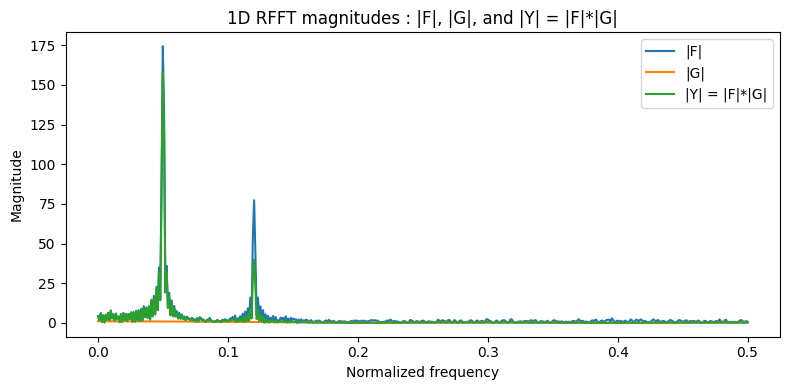

In [5]:
# 1D DEMO
np.random.seed(0)

# Signal : 합성 사인 + 약간의 노이즈
N = 512 
t = np.arange(N)
# 임시로 만든 시그널 (input data)
f = 0.7 * np.sin(2 * np.pi * 0.05 * t) + 0.3 * np.sin(2 * np.pi * 0.12 * t) + 0.05 * np.random.randn(N)

# Kernel : 5tap 이동평균 (저역통과)
g = np.ones(5) / 5.0

# [TEST 1] ====================
# 직접 컨볼루션 ('same')
y_direct = np.convolve(f, g, mode = 'same')

# [TEST 2] ====================
# FFT 기반 선형 컨볼루션 (제로패딩 -> 곱 -> 역변환 -> 길이 맞춤)
M = len(g)
# np.ceil : 올림 함수 
L = int(2 ** np.ceil(np.log2(N + M - 1))) # 선형 컨볼루션 길이 이상으로 패딩
# np.fft.rfft : 1차원 푸리에 연산 
F = np.fft.rfft(np.pad(f, (0, L - N))) # 시그널 푸리에 연산
G = np.fft.rfft(np.pad(g, (0, L - M))) # 커널 푸리에 연산 
Y = F * G # 시그널 * 커널로 새로운 신호 만듦 
y_fft_full = np.fft.irfft(Y, n = L) # 새로운 신호 푸리에 연산 역변환

# 'same' 길이로 자르기
start = (M - 1) // 2
y_fft_same = y_fft_full[start : start + N] # 새로운 신호를 푸리에 역변환 한 것을 일정한 길이로 자름 

# 상대 오차
# np.linalg.norm : 벡터 구하기
num = np.linalg.norm(y_direct - y_fft_same) # 직접 컨볼루션과 FFT 기반 선형 컨볼루션의 차이
den = np.linalg.norm(y_direct) + np.linalg.norm(y_fft_same) + 1e-12
print("[1D] relative error (direct vs FFT) : ", num / den) # 에러 오차 출력 

# 스팩트럼 확인 : |F| |G| |Y| (이론상 |Y| = |F| * |G|)
# np.fft.rfftfreq : 실수 푸리에 연산 주파수 샘플 생성 
freqs = np.fft.rfftfreq(L, d = 1.0) 
Fmag, Gmag, Ymag = np.abs(F), np.abs(G), np.abs(Y)

plt.figure(figsize = (8, 4))
plt.title("1D RFFT magnitudes : |F|, |G|, and |Y| = |F|*|G|")
plt.plot(freqs, Fmag, label = '|F|')
plt.plot(freqs, Gmag, label = '|G|')
plt.plot(freqs, Ymag, label = '|Y| = |F|*|G|')
plt.xlabel("Normalized frequency")
plt.ylabel("Magnitude")
plt.legend()
plt.tight_layout()
plt.show()

[2D] relative error (direct vs FFT) :  2.8898915732527144e-16


/var/folders/kv/v9_z1s811lg_n6c7m1gjb7w40000gn/T/ipykernel_15258/3572669246.py:33: DeprecationWarning: `axes` should not be `None` if `s` is not `None` (Deprecated in NumPy 2.0). In a future version of NumPy, this will raise an error and `s[i]` will correspond to the size along the transformed axis specified by `axes[i]`. To retain current behaviour, pass a sequence [0, ..., k-1] to `axes` for an array of dimension k.
  F2 = np.fft.rfftn(img, s = (Lh, Lw))
/var/folders/kv/v9_z1s811lg_n6c7m1gjb7w40000gn/T/ipykernel_15258/3572669246.py:34: DeprecationWarning: `axes` should not be `None` if `s` is not `None` (Deprecated in NumPy 2.0). In a future version of NumPy, this will raise an error and `s[i]` will correspond to the size along the transformed axis specified by `axes[i]`. To retain current behaviour, pass a sequence [0, ..., k-1] to `axes` for an array of dimension k.
  K2 = np.fft.rfftn(k, s = (Lh, Lw))
/var/folders/kv/v9_z1s811lg_n6c7m1gjb7w40000gn/T/ipykernel_15258/3572669246.py:3

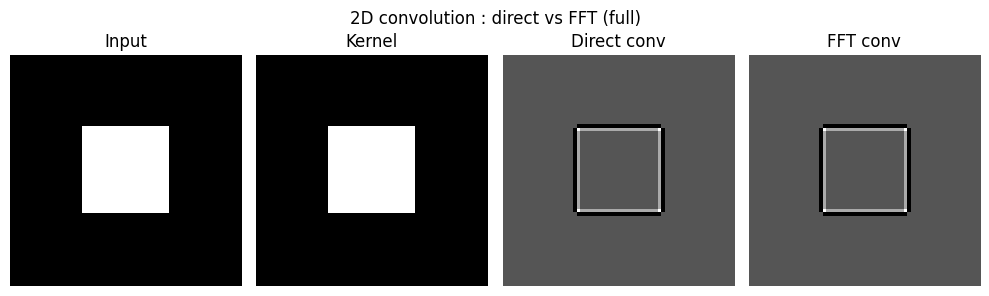

In [7]:
# 2D DEMO
# 임시 합성 이미지 : 중앙 흰 사각형
H, W = 64, 64
img = np.zeros((H, W), dtype = np.float64)
img[20:44, 20:44] = 1.0

# 2D 커널 : 라플라시안 유사 (엣지 강조)
k = np.array([[0, -1, 0], 
              [-1, 4, -1], 
              [0, -1, 0]], dtype = np.float64)

# (A) 나이브 2D 컨볼루션 (커널 뒤집어서 full conv)
def conv2d_naive(x, k):
    h, w = x.shape
    kh, kw = k.shape
    out_h, out_w = h + kh - 1, w + kw - 1
    out = np.zeros((out_h, out_w), dtype = np.float64)
    k_flip = k[::-1, ::-1]
    # 제로 패딩을 충분히 해야 선형 컨볼루션이 됨. 
    x_pad = np.pad(x, ((kh - 1, kh - 1), (kw - 1, kw - 1)))
    for i in range(out_h):
        for j in range(out_w):
            region = x_pad[i : i + kh, j : j + kw]
            out[i, j] = np.sum(region * k_flip)
    return out

y2d_direct_full = conv2d_naive(img, k)

# (B) FFT 기반 2D 선형 컨볼루션 (full)
Hf, Wf = H + k.shape[0] - 1, W + k.shape[1] - 1
Lh = int(2 ** np.ceil(np.log2(Hf)))
Lw = int(2 ** np.ceil(np.log2(Wf)))

F2 = np.fft.rfftn(img, s = (Lh, Lw))
K2 = np.fft.rfftn(k, s = (Lh, Lw))
Y2 = F2 * K2
y2d_fft_full_padded = np.fft.irfftn(Y2, s = (Lh, Lw))
y2d_fft_full = y2d_fft_full_padded[:Hf, :Wf]

# 상대오차
num = np.linalg.norm(y2d_direct_full - y2d_fft_full)
# 0으로 나눠지는 것을 방지하기 위해 den에 앱실론을 추가함.
den = np.linalg.norm(y2d_direct_full) + np.linalg.norm(y2d_fft_full) + 1e-12
print("[2D] relative error (direct vs FFT) : ", num / den)

# 시각화
plt.figure(figsize = (10, 3))
plt.suptitle("2D convolution : direct vs FFT (full)")
plt.subplot(1, 4, 1)
plt.title("Input")
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.title("Kernel")
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.title("Direct conv")
plt.imshow(y2d_direct_full, cmap = 'gray')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.title("FFT conv")
plt.imshow(y2d_fft_full, cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.show()